In [35]:
"""
Notebook: 03_feature_engineering.ipynb
Engineer structured features from MIMIC-III data for readmission prediction
"""

# Cell 1: Setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import json
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

# Load config
with open('../configs/config.json', 'r') as f:
    config = json.load(f)

data_dir = Path('../data/raw')
processed_dir = Path('../data/processed')

print("✓ Setup complete")



✓ Setup complete


In [36]:
# Cell 2: Load Cohort and Supporting Tables
"""
Load cohort and all tables needed for feature engineering
"""
print("Loading data...")

# Load our cohort
cohort = pd.read_parquet(processed_dir / 'cohort_with_outcomes.parquet')
print(f"✓ Loaded cohort: {len(cohort)} admissions")

# Load supporting tables
diagnoses = pd.read_csv(data_dir / 'DIAGNOSES_ICD.csv')
procedures = pd.read_csv(data_dir / 'PROCEDURES_ICD.csv')
prescriptions = pd.read_csv(data_dir / 'PRESCRIPTIONS.csv')
labevents = pd.read_csv(data_dir / 'LABEVENTS.csv')
icustays = pd.read_csv(data_dir / 'ICUSTAYS.csv')

# Load diagnosis/procedure lookup tables
d_icd_diagnoses = pd.read_csv(data_dir / 'D_ICD_DIAGNOSES.csv')
d_labitems = pd.read_csv(data_dir / 'D_LABITEMS.csv')

print(f"✓ Loaded {len(diagnoses)} diagnoses")
print(f"✓ Loaded {len(procedures)} procedures")
print(f"✓ Loaded {len(prescriptions)} prescriptions")
print(f"✓ Loaded {len(labevents)} lab events")
print(f"✓ Loaded {len(icustays)} ICU stays")


Loading data...
✓ Loaded cohort: 79 admissions
✓ Loaded 1761 diagnoses
✓ Loaded 506 procedures
✓ Loaded 10398 prescriptions
✓ Loaded 76074 lab events
✓ Loaded 136 ICU stays


In [37]:
# Cell 3: Feature Set 1 - Demographics
"""
Extract demographic features
"""
print("\n" + "="*60)
print("FEATURE SET 1: DEMOGRAPHICS")
print("="*60)

features = cohort[['HADM_ID', 'SUBJECT_ID']].copy()

# Age (already calculated in cohort)
features['age'] = cohort['AGE']

# Age bins
features['age_group'] = pd.cut(cohort['AGE'], 
                               bins=[0, 40, 65, 80, 150], 
                               labels=['18-40', '41-65', '66-80', '80+'])
features['age_group'] = features['age_group'].astype(str)

# Gender (binary encode)
features['gender_M'] = (cohort['GENDER'] == 'M').astype(int)
features['gender_F'] = (cohort['GENDER'] == 'F').astype(int)

# Ethnicity (group into major categories)
def categorize_ethnicity(eth):
    if pd.isna(eth):
        return 'UNKNOWN'
    eth = eth.upper()
    if 'WHITE' in eth:
        return 'WHITE'
    elif 'BLACK' in eth or 'AFRICAN' in eth:
        return 'BLACK'
    elif 'HISPANIC' in eth or 'LATINO' in eth:
        return 'HISPANIC'
    elif 'ASIAN' in eth:
        return 'ASIAN'
    else:
        return 'OTHER'

features['ethnicity_category'] = cohort['ETHNICITY'].apply(categorize_ethnicity)
ethnicity_dummies = pd.get_dummies(features['ethnicity_category'], prefix='ethnicity')
features = pd.concat([features, ethnicity_dummies], axis=1)

# Insurance type
insurance_dummies = pd.get_dummies(cohort['INSURANCE'], prefix='insurance')
features = pd.concat([features, insurance_dummies], axis=1)

# Marital status
marital_dummies = pd.get_dummies(cohort['MARITAL_STATUS'].fillna('UNKNOWN'), prefix='marital')
features = pd.concat([features, marital_dummies], axis=1)

print(f"✓ Demographic features: {len([c for c in features.columns if c not in ['HADM_ID', 'SUBJECT_ID']])}")
print(f"   - Age (continuous + binned)")
print(f"   - Gender (2 features)")
print(f"   - Ethnicity ({len(ethnicity_dummies.columns)} categories)")
print(f"   - Insurance ({len(insurance_dummies.columns)} types)")
print(f"   - Marital status ({len(marital_dummies.columns)} categories)")




FEATURE SET 1: DEMOGRAPHICS
✓ Demographic features: 20
   - Age (continuous + binned)
   - Gender (2 features)
   - Ethnicity (5 categories)
   - Insurance (3 types)
   - Marital status (7 categories)


In [38]:
# Cell 4: Feature Set 2 - Admission Characteristics
"""
Admission-related features
"""
print("\n" + "="*60)
print("FEATURE SET 2: ADMISSION CHARACTERISTICS")
print("="*60)

# Length of stay
features['los_days'] = cohort['LOS_DAYS']
features['los_hours'] = cohort['LOS_DAYS'] * 24

# LOS categories
features['los_category'] = pd.cut(cohort['LOS_DAYS'], 
                                  bins=[0, 2, 5, 10, 999], 
                                  labels=['short', 'medium', 'long', 'very_long'])
los_dummies = pd.get_dummies(features['los_category'], prefix='los')
features = pd.concat([features, los_dummies], axis=1)

# Admission type (already filtered to EMERGENCY/URGENT)
admission_type_dummies = pd.get_dummies(cohort['ADMISSION_TYPE'], prefix='admission_type')
features = pd.concat([features, admission_type_dummies], axis=1)

# Admission location
admission_loc_dummies = pd.get_dummies(cohort['ADMISSION_LOCATION'].fillna('UNKNOWN'), prefix='admit_loc')
features = pd.concat([features, admission_loc_dummies], axis=1)

# Discharge location (important predictor)
discharge_loc_dummies = pd.get_dummies(cohort['DISCHARGE_LOCATION'].fillna('UNKNOWN'), prefix='discharge_loc')
features = pd.concat([features, discharge_loc_dummies], axis=1)

# Temporal features
features['admit_hour'] = pd.to_datetime(cohort['ADMITTIME']).dt.hour
features['admit_dayofweek'] = pd.to_datetime(cohort['ADMITTIME']).dt.dayofweek
features['admit_weekend'] = (features['admit_dayofweek'] >= 5).astype(int)

features['discharge_hour'] = pd.to_datetime(cohort['DISCHTIME']).dt.hour
features['discharge_dayofweek'] = pd.to_datetime(cohort['DISCHTIME']).dt.dayofweek
features['discharge_weekend'] = (features['discharge_dayofweek'] >= 5).astype(int)

# Season
features['discharge_month'] = pd.to_datetime(cohort['DISCHTIME']).dt.month
features['discharge_season'] = features['discharge_month'].apply(
    lambda m: 'winter' if m in [12, 1, 2] else
              'spring' if m in [3, 4, 5] else
              'summer' if m in [6, 7, 8] else 'fall'
)
season_dummies = pd.get_dummies(features['discharge_season'], prefix='season')
features = pd.concat([features, season_dummies], axis=1)

print(f"✓ Admission features: {12 + len(los_dummies.columns) + len(admission_type_dummies.columns) + len(admission_loc_dummies.columns) + len(discharge_loc_dummies.columns) + len(season_dummies.columns)}")




FEATURE SET 2: ADMISSION CHARACTERISTICS
✓ Admission features: 35


In [39]:
# Cell 5: Feature Set 3 - Diagnoses & Comorbidities
"""
Diagnosis-based features including comorbidity scores
"""
print("\n" + "="*60)
print("FEATURE SET 3: DIAGNOSES & COMORBIDITIES")
print("="*60)

# Ensure uppercase columns
diagnoses.columns = diagnoses.columns.str.upper()
d_icd_diagnoses.columns = d_icd_diagnoses.columns.str.upper()
features.columns = features.columns.str.upper()

# Merge diagnoses with descriptions
diagnoses_full = diagnoses.merge(
    d_icd_diagnoses[['ICD9_CODE', 'LONG_TITLE']], 
    on='ICD9_CODE', 
    how='left'
)

# Count total diagnoses per admission
diag_counts = diagnoses.groupby('HADM_ID').size().reset_index(name='N_DIAGNOSES')
features = features.merge(diag_counts, on='HADM_ID', how='left')
features['N_DIAGNOSES'] = features['N_DIAGNOSES'].fillna(0)

# Simplified Charlson Comorbidity Index
def get_charlson_score(hadm_id):
    """Calculate simplified Charlson score based on ICD-9 codes"""
    hadm_diagnoses = diagnoses[diagnoses['HADM_ID'] == hadm_id]['ICD9_CODE'].astype(str).tolist()
    score = 0
    conditions = {
        'MI': ['410', '412'],  
        'CHF': ['428'],  
        'PVD': ['441', '443', '785.4'],  
        'CVD': ['430', '431', '432', '433', '434', '435', '436', '437', '438'],  
        'Dementia': ['290'],  
        'COPD': ['490', '491', '492', '493', '494', '495', '496', '500', '501', '502', '503', '504', '505'],
        'Diabetes': ['250'],  
        'Renal': ['582', '583', '585', '586', '588'],  
        'Liver': ['571'],  
        'Cancer': ['14', '15', '16', '17', '18', '19', '20']  
    }
    for condition, codes in conditions.items():
        for code in codes:
            if any(diag.startswith(code) for diag in hadm_diagnoses):
                score += 1
                break
    return score

# Calculate Charlson for each admission
print("Calculating Charlson comorbidity scores...")
features['CHARLSON_SCORE'] = features['HADM_ID'].apply(get_charlson_score)

# High-risk condition flags
def has_condition(hadm_id, code_prefixes):
    """Check if admission has any diagnosis starting with given code prefixes"""
    hadm_diagnoses = diagnoses[diagnoses['HADM_ID'] == hadm_id]['ICD9_CODE'].astype(str).tolist()
    return int(any(any(diag.startswith(code) for code in code_prefixes) for diag in hadm_diagnoses))

print("Flagging high-risk conditions...")
features['DX_HEART_FAILURE'] = features['HADM_ID'].apply(lambda x: has_condition(x, ['428']))
features['DX_COPD'] = features['HADM_ID'].apply(lambda x: has_condition(x, ['490', '491', '492', '493', '494', '496']))
features['DX_DIABETES'] = features['HADM_ID'].apply(lambda x: has_condition(x, ['250']))
features['DX_RENAL_FAILURE'] = features['HADM_ID'].apply(lambda x: has_condition(x, ['584', '585', '586']))
features['DX_CANCER'] = features['HADM_ID'].apply(lambda x: has_condition(x, ['14', '15', '16', '17', '18', '19', '20']))
features['DX_SEPSIS'] = features['HADM_ID'].apply(lambda x: has_condition(x, ['038', '995.91', '995.92']))

print(f"✓ Diagnosis features: 7 (count + Charlson + 5 high-risk flags)")
print(f"   Mean Charlson score: {features['CHARLSON_SCORE'].mean():.2f}")



FEATURE SET 3: DIAGNOSES & COMORBIDITIES
Calculating Charlson comorbidity scores...
Flagging high-risk conditions...
✓ Diagnosis features: 7 (count + Charlson + 5 high-risk flags)
   Mean Charlson score: 1.91


In [40]:
# Cell 6: Feature Set 4 - Procedures
"""
Procedure-based features
"""
print("\n" + "="*60)
print("FEATURE SET 4: PROCEDURES")
print("="*60)

# Ensure uppercase columns
procedures.columns = procedures.columns.str.upper()
features.columns = features.columns.str.upper()

# Count procedures per admission
proc_counts = procedures.groupby('HADM_ID').size().reset_index(name='N_PROCEDURES')
features = features.merge(proc_counts, on='HADM_ID', how='left')
features['N_PROCEDURES'] = features['N_PROCEDURES'].fillna(0)

# Major procedure flags (simplified)
features['PROC_SURGERY'] = features['HADM_ID'].apply(
    lambda x: int(len(procedures[procedures['HADM_ID'] == x]) > 0)
)

print(f"✓ Procedure features: 2 (count + surgery flag)")



FEATURE SET 4: PROCEDURES
✓ Procedure features: 2 (count + surgery flag)


In [41]:
# Cell 7: Feature Set 5 - ICU Utilization
"""
ICU stay features
"""
print("\n" + "="*60)
print("FEATURE SET 5: ICU UTILIZATION")
print("="*60)

# Uppercase ICU columns
icustays.columns = icustays.columns.str.upper()
features.columns = features.columns.str.upper()

# Convert ICU times
icustays['INTIME'] = pd.to_datetime(icustays['INTIME'], errors='coerce')
icustays['OUTTIME'] = pd.to_datetime(icustays['OUTTIME'], errors='coerce')

# ICU length of stay (days)
icustays['ICU_LOS'] = (icustays['OUTTIME'] - icustays['INTIME']).dt.total_seconds() / 86400

# ICU stay summary per admission
icu_patients = icustays.groupby('HADM_ID').agg({
    'ICUSTAY_ID': 'count',
    'ICU_LOS': 'sum'
}).reset_index()
icu_patients.columns = ['HADM_ID', 'N_ICU_STAYS', 'TOTAL_ICU_DAYS']

# Merge with features
features = features.merge(icu_patients, on='HADM_ID', how='left')
features['N_ICU_STAYS'] = features['N_ICU_STAYS'].fillna(0)
features['TOTAL_ICU_DAYS'] = features['TOTAL_ICU_DAYS'].fillna(0)
features['HAD_ICU_STAY'] = (features['N_ICU_STAYS'] > 0).astype(int)

print(f"✓ ICU features: 3 (count, days, flag)")
print(f"   Admissions with ICU: {features['HAD_ICU_STAY'].sum()} ({features['HAD_ICU_STAY'].mean()*100:.1f}%)")



FEATURE SET 5: ICU UTILIZATION
✓ ICU features: 3 (count, days, flag)
   Admissions with ICU: 79 (100.0%)


In [42]:
# Cell 8: Feature Set 6 - Medications
"""
Medication-based features
"""
print("\n" + "="*60)
print("FEATURE SET 6: MEDICATIONS")
print("="*60)

# Ensure uppercase columns
prescriptions.columns = prescriptions.columns.str.upper()

# Count unique medications per admission
med_counts = prescriptions.groupby('HADM_ID')['DRUG'].nunique().reset_index(name='n_medications')
features = features.merge(med_counts, on='HADM_ID', how='left')
features['n_medications'] = features['n_medications'].fillna(0)

# High-risk medication classes (simplified keyword search)
def has_medication_class(hadm_id, keywords):
    """Check if admission has medications matching keywords"""
    hadm_meds = prescriptions[prescriptions['HADM_ID'] == hadm_id]['DRUG'].astype(str).str.upper().tolist()
    return int(any(any(keyword in med for keyword in keywords) for med in hadm_meds))

print("Checking medication classes...")
features['med_anticoagulant'] = features['HADM_ID'].apply(
    lambda x: has_medication_class(x, ['WARFARIN', 'HEPARIN', 'COUMADIN'])
)
features['med_diuretic'] = features['HADM_ID'].apply(
    lambda x: has_medication_class(x, ['FUROSEMIDE', 'LASIX'])
)
features['med_insulin'] = features['HADM_ID'].apply(
    lambda x: has_medication_class(x, ['INSULIN'])
)

print(f"✓ Medication features: 4 (count + 3 drug class flags)")




FEATURE SET 6: MEDICATIONS
Checking medication classes...
✓ Medication features: 4 (count + 3 drug class flags)


In [43]:
# Cell 9: Feature Set 7 - Laboratory Values
"""
Lab values - last measurements before discharge
"""
print("\n" + "="*60)
print("FEATURE SET 7: LABORATORY VALUES")
print("="*60)

# Ensure uppercase columns
labevents.columns = labevents.columns.str.upper()
d_labitems.columns = d_labitems.columns.str.upper()

# Convert lab times
labevents['CHARTTIME'] = pd.to_datetime(labevents['CHARTTIME'])

# Merge with cohort to get discharge times
labs_with_discharge = labevents.merge(
    cohort[['HADM_ID', 'DISCHTIME']], 
    on='HADM_ID', 
    how='inner'
)

# Keep only labs before discharge
labs_with_discharge = labs_with_discharge[
    labs_with_discharge['CHARTTIME'] <= labs_with_discharge['DISCHTIME']
]

# Get lab item names
labs_with_discharge = labs_with_discharge.merge(
    d_labitems[['ITEMID', 'LABEL']], 
    on='ITEMID', 
    how='left'
)

# Define key lab values to extract
key_labs = {
    'Creatinine': ['CREATININE'],
    'Hemoglobin': ['HEMOGLOBIN', 'HGB'],
    'Platelet': ['PLATELET'],
    'WBC': ['WBC', 'WHITE BLOOD CELLS'],
    'Sodium': ['SODIUM'],
    'Potassium': ['POTASSIUM'],
    'Glucose': ['GLUCOSE']
}

# Extract last value for each key lab per admission
for lab_name, keywords in key_labs.items():
    print(f"Extracting {lab_name}...")
    
    # Filter to relevant lab
    lab_data = labs_with_discharge[
        labs_with_discharge['LABEL'].str.upper().str.contains('|'.join(keywords), na=False)
    ].copy()
    
    # Get last value per admission
    last_values = lab_data.sort_values('CHARTTIME').groupby('HADM_ID').last()['VALUENUM'].reset_index()
    last_values.columns = ['HADM_ID', f'lab_{lab_name.lower()}_last']
    
    features = features.merge(last_values, on='HADM_ID', how='left')

# Count of lab measurements (indicator of monitoring intensity)
lab_intensity = labevents.groupby('HADM_ID').size().reset_index(name='n_lab_measurements')
features = features.merge(lab_intensity, on='HADM_ID', how='left')
features['n_lab_measurements'] = features['n_lab_measurements'].fillna(0)

print(f"✓ Lab features: {len(key_labs) + 1}")




FEATURE SET 7: LABORATORY VALUES
Extracting Creatinine...
Extracting Hemoglobin...
Extracting Platelet...
Extracting WBC...
Extracting Sodium...
Extracting Potassium...
Extracting Glucose...
✓ Lab features: 8


In [44]:
# Cell 10: Feature Set 8 - Utilization History
"""
Prior utilization patterns - strong readmission predictors
"""
print("\n" + "="*60)
print("FEATURE SET 8: UTILIZATION HISTORY")
print("="*60)

# Read all admissions first
all_admissions = pd.read_csv(data_dir / 'ADMISSIONS.csv')

# Uppercase columns
all_admissions.columns = all_admissions.columns.str.upper()
cohort.columns = cohort.columns.str.upper()
features.columns = features.columns.str.upper()

# Ensure datetime
all_admissions['ADMITTIME'] = pd.to_datetime(all_admissions['ADMITTIME'], errors='coerce')
all_admissions['DISCHTIME'] = pd.to_datetime(all_admissions['DISCHTIME'], errors='coerce')

# For each admission in cohort, count prior admissions
def count_prior_admissions(row, window_days):
    """Count admissions in the window_days before this admission"""
    subject_id = row['SUBJECT_ID']
    admit_time = row['ADMITTIME']
    
    # Get all prior admissions for this patient
    prior = all_admissions[
        (all_admissions['SUBJECT_ID'] == subject_id) &
        (all_admissions['DISCHTIME'] < admit_time) &
        (all_admissions['DISCHTIME'] >= admit_time - pd.Timedelta(days=window_days))
    ]
    
    return len(prior)

print("Calculating prior admission history...")
features['PRIOR_ADMISSIONS_90D'] = cohort.apply(lambda row: count_prior_admissions(row, 90), axis=1)
features['PRIOR_ADMISSIONS_180D'] = cohort.apply(lambda row: count_prior_admissions(row, 180), axis=1)
features['PRIOR_ADMISSIONS_365D'] = cohort.apply(lambda row: count_prior_admissions(row, 365), axis=1)

# Frequent flyer flag (3+ admissions in 6 months)
features['FREQUENT_FLYER'] = (features['PRIOR_ADMISSIONS_180D'] >= 3).astype(int)

print(f"✓ Utilization history features: 4")
print(f"   Frequent flyers: {features['FREQUENT_FLYER'].sum()} ({features['FREQUENT_FLYER'].mean()*100:.1f}%)")



FEATURE SET 8: UTILIZATION HISTORY
Calculating prior admission history...
✓ Utilization history features: 4
   Frequent flyers: 3 (3.8%)


In [45]:
# Cell 11: Handle Missing Values
"""
Implement missing value strategy
"""
print("\n" + "="*60)
print("HANDLING MISSING VALUES")
print("="*60)

# Check missing values
missing_summary = features.isnull().sum()
missing_summary = missing_summary[missing_summary > 0].sort_values(ascending=False)

print("Features with missing values:")
print(missing_summary)

# Strategy: Create missingness indicators for labs, then impute with median
lab_cols = [col for col in features.columns if col.startswith('lab_')]

for col in lab_cols:
    # Create missingness indicator
    features[f'{col}_missing'] = features[col].isnull().astype(int)
    
    # Impute with median (only if there are non-null values)
    if features[col].notna().sum() > 0:
        median_val = features[col].median()
        features[col] = features[col].fillna(median_val)
    else:
        features[col] = features[col].fillna(0)

print(f"\n✓ Created {len(lab_cols)} missingness indicators")
print("✓ Imputed missing lab values with median")

# Drop any remaining text/categorical columns used for intermediate processing
columns_to_drop = ['AGE_GROUP', 'ETHNICITY_CATEGORY', 'LOS_CATEGORY', 'DISCHARGE_SEASON']
features = features.drop([col for col in columns_to_drop if col in features.columns], axis=1, errors='ignore')

# Add verification:
object_cols = features.select_dtypes(include=['object']).columns.tolist()
if object_cols:
    print(f"⚠️ Warning: Object columns still present: {object_cols}")
    cols_to_keep = ['HADM_ID', 'SUBJECT_ID']
    features = features.drop([col for col in object_cols if col not in cols_to_keep], axis=1, errors='ignore')
else:
    print("✓ All categorical columns successfully removed")




HANDLING MISSING VALUES
Features with missing values:
Series([], dtype: int64)

✓ Created 0 missingness indicators
✓ Imputed missing lab values with median
✓ All categorical columns successfully removed


In [46]:
# Cell 12: Add Target Variable and Create Final Dataset
"""
Merge with outcomes and create final feature matrix
"""
print("\n" + "="*60)
print("CREATING FINAL FEATURE MATRIX")
print("="*60)

# Add target variable
features['target_readmit_30'] = cohort['READMIT_30'].astype(int)
features['is_last_admission'] = cohort['IS_LAST_ADMISSION'].astype(int)

# Add text availability flag
features['has_discharge_note'] = cohort['HAS_DISCHARGE_NOTE'].astype(int)

# Separate feature columns from metadata
metadata_cols = ['HADM_ID', 'SUBJECT_ID', 'target_readmit_30', 'is_last_admission', 'has_discharge_note']
feature_cols = [col for col in features.columns if col not in metadata_cols]

print(f"Total engineered features: {len(feature_cols)}")
print(f"Metadata columns: {len(metadata_cols)}")
print(f"Total columns: {len(features.columns)}")

# Check for any remaining missing values
remaining_missing = features[feature_cols].isnull().sum().sum()
if remaining_missing > 0:
    print(f"\n⚠️  Warning: {remaining_missing} missing values remaining")
    print("Filling with 0...")
    features[feature_cols] = features[feature_cols].fillna(0)
else:
    print("\n✓ No missing values in features")




CREATING FINAL FEATURE MATRIX
Total engineered features: 79
Metadata columns: 5
Total columns: 84

✓ No missing values in features


In [47]:
# Cell 13: Feature Statistics and Importance Preview
"""
Analyze feature distributions
"""
print("\n" + "="*60)
print("FEATURE STATISTICS")
print("="*60)

# Ensure column names are uppercase
features.columns = features.columns.str.upper()

# Numeric feature summary
numeric_features = features[feature_cols].select_dtypes(include=[np.number])
print(f"\nNumeric features: {len(numeric_features.columns)}")
print("\nSample statistics:")
print(numeric_features.describe().T[['mean', 'std', 'min', 'max']].head(10))

# Check for constant features (zero variance)
constant_features = [col for col in numeric_features.columns if features[col].nunique() <= 1]
if constant_features:
    print(f"\n⚠️  Warning: {len(constant_features)} constant features found:")
    print(constant_features[:10])
    print("Consider removing these in modeling")

# Check feature correlations with target (for evaluable admissions only)
if 'IS_LAST_ADMISSION' in features.columns and 'TARGET_READMIT_30' in features.columns:
    evaluable = features[features['IS_LAST_ADMISSION'] == 0].copy()
    numeric_evaluable = evaluable[numeric_features.columns.tolist() + ['TARGET_READMIT_30']].select_dtypes(include=[np.number])
    if len(numeric_evaluable) > 0:
        print(f"\nTop 10 features correlated with readmission:")
        correlations = numeric_evaluable.corr()['TARGET_READMIT_30'].abs().sort_values(ascending=False)[1:11]
        for feat, corr in correlations.items():
            print(f"  {feat:40s}: {corr:.3f}")



FEATURE STATISTICS

Numeric features: 41

Sample statistics:
                           mean         std   min          max
AGE                   72.227848   17.593668  27.0   120.000000
GENDER_M               0.607595    0.491406   0.0     1.000000
GENDER_F               0.392405    0.491406   0.0     1.000000
LOS_DAYS               9.525352   14.252011   1.0   123.984722
LOS_HOURS            228.608439  342.048264  24.0  2975.633333
ADMIT_HOUR            13.670886    6.517671   0.0    23.000000
ADMIT_DAYOFWEEK        2.822785    2.116840   0.0     6.000000
ADMIT_WEEKEND          0.316456    0.468065   0.0     1.000000
DISCHARGE_HOUR        14.810127    2.259317   9.0    19.000000
DISCHARGE_DAYOFWEEK    2.734177    1.582831   0.0     6.000000

⚠️  Warning: 1 constant features found:
['HAD_ICU_STAY']
Consider removing these in modeling

Top 10 features correlated with readmission:
  LAB_POTASSIUM_LAST                      : 0.538
  DX_DIABETES                             : 0.447
  ADM

In [48]:
# Cell 14: Create Train/Calibration/Test Splits
"""
Split data temporally to prevent leakage
"""
print("\n" + "="*60)
print("CREATING DATA SPLITS")
print("="*60)

# Ensure cohort and features have consistent column names
cohort.columns = cohort.columns.str.upper()
features.columns = features.columns.str.upper()

# Mark last admission per patient
last_admissions = cohort.groupby('SUBJECT_ID')['DISCHTIME'].idxmax()
features['IS_LAST_ADMISSION'] = 0
features.loc[last_admissions, 'IS_LAST_ADMISSION'] = 1

# Temporal split based on discharge time
cohort_with_time = cohort[['HADM_ID', 'DISCHTIME']].copy()
features_with_time = features.merge(cohort_with_time, on='HADM_ID')
features_with_time = features_with_time.sort_values('DISCHTIME')

# Remove last admissions (can't evaluate outcome)
evaluable_data = features_with_time[features_with_time['IS_LAST_ADMISSION'] == 0].copy()

print(f"Total admissions: {len(features)}")
print(f"Evaluable admissions (excluding last per patient): {len(evaluable_data)}")

# Split: 70% train, 10% calibration, 20% test (temporal)
n_total = len(evaluable_data)
n_train = int(n_total * 0.7)
n_calib = int(n_total * 0.1)

train_data = evaluable_data.iloc[:n_train]
calib_data = evaluable_data.iloc[n_train:n_train+n_calib]
test_data = evaluable_data.iloc[n_train+n_calib:]

print(f"\nSplit sizes:")
print(f"  Training:    {len(train_data):4d} ({len(train_data)/n_total*100:.1f}%)")
print(f"  Calibration: {len(calib_data):4d} ({len(calib_data)/n_total*100:.1f}%)")
print(f"  Test:        {len(test_data):4d} ({len(test_data)/n_total*100:.1f}%)")

# Check readmission rates in each split
print(f"\nReadmission rates:")
print(f"  Training:    {train_data['TARGET_READMIT_30'].mean()*100:.2f}%")
print(f"  Calibration: {calib_data['TARGET_READMIT_30'].mean()*100:.2f}%")
print(f"  Test:        {test_data['TARGET_READMIT_30'].mean()*100:.2f}%")



CREATING DATA SPLITS
Total admissions: 79
Evaluable admissions (excluding last per patient): 21

Split sizes:
  Training:      14 (66.7%)
  Calibration:    2 (9.5%)
  Test:           5 (23.8%)

Readmission rates:
  Training:    35.71%
  Calibration: 0.00%
  Test:        20.00%


In [49]:
# Cell 15: Save Datasets
"""
Save processed datasets for modeling
"""
print("\n" + "="*60)
print("SAVING PROCESSED DATASETS")
print("="*60)

# Drop DISCHTIME before saving
train_data = train_data.drop('DISCHTIME', axis=1)
calib_data = calib_data.drop('DISCHTIME', axis=1)
test_data = test_data.drop('DISCHTIME', axis=1)

# Save as parquet (efficient storage)
train_data.to_parquet(processed_dir / 'train_features.parquet', index=False)
calib_data.to_parquet(processed_dir / 'calibration_features.parquet', index=False)
test_data.to_parquet(processed_dir / 'test_features.parquet', index=False)

print(f"✓ Saved training set: {train_data.shape}")
print(f"✓ Saved calibration set: {calib_data.shape}")
print(f"✓ Saved test set: {test_data.shape}")

# Also save feature names for reference
feature_info = {
    'n_features': len(feature_cols),
    'feature_names': feature_cols,
    'metadata_cols': metadata_cols,
    'target_variable': 'target_readmit_30'
}

with open(processed_dir / 'feature_info.json', 'w') as f:
    json.dump(feature_info, f, indent=2)

print(f"✓ Saved feature metadata")

# Save feature list as text for easy reference
with open(processed_dir / 'feature_list.txt', 'w') as f:
    f.write("TRANCE Structured Features\n")
    f.write("="*60 + "\n\n")
    for i, feat in enumerate(feature_cols, 1):
        f.write(f"{i:3d}. {feat}\n")

print(f"✓ Saved feature list")




SAVING PROCESSED DATASETS
✓ Saved training set: (14, 84)
✓ Saved calibration set: (2, 84)
✓ Saved test set: (5, 84)
✓ Saved feature metadata
✓ Saved feature list



✓ Visualization saved


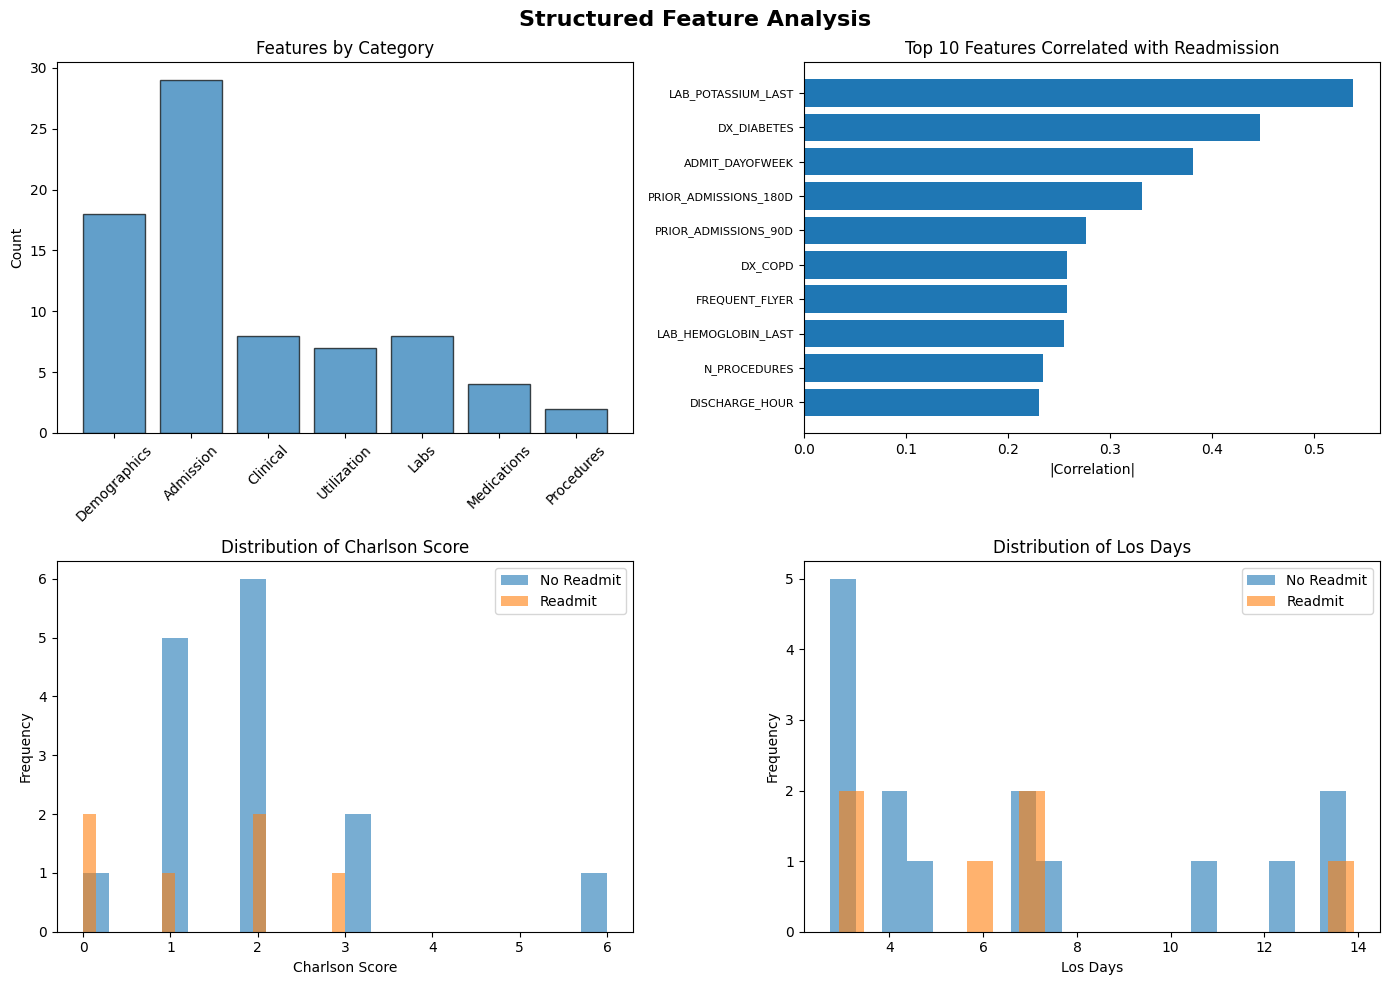

In [50]:
# Cell 16: Visualization
"""
Visualize feature distributions and correlations
"""
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Structured Feature Analysis', fontsize=16, fontweight='bold')

# Ensure column names are uppercase
features.columns = features.columns.str.upper()
evaluable = features[features['IS_LAST_ADMISSION'] == 0].copy()
target_col = 'TARGET_READMIT_30'

# 1. Feature count by category
feature_categories = {
    'Demographics': len([f for f in feature_cols if any(x in f.lower() for x in ['age', 'gender', 'ethnicity', 'insurance', 'marital'])]),
    'Admission': len([f for f in feature_cols if any(x in f.lower() for x in ['los', 'admission', 'discharge', 'season', 'weekend'])]),
    'Clinical': len([f for f in feature_cols if any(x in f.lower() for x in ['dx_', 'charlson', 'n_diagnoses'])]),
    'Utilization': len([f for f in feature_cols if any(x in f.lower() for x in ['prior', 'frequent', 'icu'])]),
    'Labs': len([f for f in feature_cols if 'lab_' in f.lower()]),
    'Medications': len([f for f in feature_cols if 'med_' in f.lower() or 'n_medications' in f.lower()]),
    'Procedures': len([f for f in feature_cols if 'proc' in f.lower() or 'n_procedures' in f.lower()])
}

axes[0, 0].bar(feature_categories.keys(), feature_categories.values(), edgecolor='black', alpha=0.7)
axes[0, 0].set_ylabel('Count')
axes[0, 0].set_title('Features by Category')
axes[0, 0].tick_params(axis='x', rotation=45)

# 2. Top correlated features
if target_col in evaluable.columns:
    numeric_features = evaluable[feature_cols + [target_col]].select_dtypes(include=[np.number])
    top_corr = numeric_features.corr()[target_col].abs().sort_values(ascending=False)[1:11]
    axes[0, 1].barh(range(len(top_corr)), top_corr.values)
    axes[0, 1].set_yticks(range(len(top_corr)))
    axes[0, 1].set_yticklabels([f[:30] for f in top_corr.index], fontsize=8)
    axes[0, 1].set_xlabel('|Correlation|')
    axes[0, 1].set_title('Top 10 Features Correlated with Readmission')
    axes[0, 1].invert_yaxis()
else:
    print(f"⚠️  Column '{target_col}' not found in evaluable data. Skipping correlation plot.")

# 3. Key feature distributions by readmission
key_features_plot = ['CHARLSON_SCORE', 'LOS_DAYS', 'PRIOR_ADMISSIONS_180D', 'N_MEDICATIONS']
for i, feat in enumerate(key_features_plot[:2]):
    if feat in evaluable.columns and target_col in evaluable.columns:
        evaluable.groupby(target_col)[feat].plot.hist(alpha=0.6, ax=axes[1, i], bins=20, legend=True)
        axes[1, i].set_xlabel(feat.replace('_', ' ').title())
        axes[1, i].set_ylabel('Frequency')
        axes[1, i].set_title(f'Distribution of {feat.replace("_", " ").title()}')
        axes[1, i].legend(['No Readmit', 'Readmit'])

plt.tight_layout()
plt.savefig('../outputs/figures/feature_engineering_summary.png', dpi=300, bbox_inches='tight')
print("\n✓ Visualization saved")
plt.show()


In [51]:
# Cell 17: Summary
print("\n" + "="*60)
print("FEATURE ENGINEERING COMPLETE!")
print("="*60)

target_col = 'TARGET_READMIT_30'  # use uppercase

print(f"\n✅ Engineered {len(feature_cols)} structured features")
print(f"✅ Created train/calibration/test splits")
if target_col in evaluable.columns:
    print(f"✅ Readmission rate: {evaluable[target_col].mean()*100:.2f}%")
else:
    print(f"⚠️  Column '{target_col}' not found in evaluable data")

print(f"\n📊 Outputs:")
print(f"   - data/processed/train_features.parquet")
print(f"   - data/processed/calibration_features.parquet")
print(f"   - data/processed/test_features.parquet")
print(f"   - data/processed/feature_info.json")
print(f"   - outputs/figures/feature_engineering_summary.png")

print(f"\n📝 Next Steps:")
print("   1. Generate clinical text embeddings (04_generate_embeddings.ipynb)")
print("   2. Train baseline and fused models (05_train_models.ipynb)")
print("   3. Evaluate and calibrate predictions")



FEATURE ENGINEERING COMPLETE!

✅ Engineered 79 structured features
✅ Created train/calibration/test splits
✅ Readmission rate: 28.57%

📊 Outputs:
   - data/processed/train_features.parquet
   - data/processed/calibration_features.parquet
   - data/processed/test_features.parquet
   - data/processed/feature_info.json
   - outputs/figures/feature_engineering_summary.png

📝 Next Steps:
   1. Generate clinical text embeddings (04_generate_embeddings.ipynb)
   2. Train baseline and fused models (05_train_models.ipynb)
   3. Evaluate and calibrate predictions
